### About Dataset
##### Overview
The mobile games industry is worth billions of dollars, with companies spending vast amounts of money on the development and marketing of these games to an equally large market. Using this data set, insights can be gained into a sub-market of this market, strategy games. This sub-market includes titles such as Clash of Clans, Plants vs Zombies and Pokemon GO.

#### Background
This is the data of 17007 strategy games on the Apple App Store. It was collected on the 3rd of August 2019, using the iTunes API and the App Store sitemap.

#### Some ideas
You could use the number of ratings as a proxy indicator for the overall success of a game, and then work out what factors make a successful game. Or you could measure the state of the market over time and try predict where it is headed
______


# Главная задача: посмотреть на данные во всевзможных разрезах и понять какие игры становятся самыми популярными у пользователей
_____

In [76]:
# загрузим нужные библиотеки
import pandas as pd
import numpy as np

# визуализация
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set_palette('husl')

import datetime as dt

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))


In [51]:
# читаем данные
data = pd.read_csv('appstore_games.csv')
# убираем ненужные колонки
data.drop(columns = ['URL', 'Icon URL', 'Subtitle'], inplace = True)
# меняем названия колонок для удобства
data.columns = data.columns.str.replace(' ', '_')
data.head()

,ID,Name,Average_User_Rating,User_Rating_Count,Price,In-app_Purchases,Description,Developer,Age_Rating,Languages,Size,Primary_Genre,Genres,Original_Release_Date,Current_Version_Release_Date
0,284921427,Sudoku,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,284926400,Reversi,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,284946595,Morocco,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,285755462,Sudoku (Free),3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,285831220,Senet Deluxe,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


### Проведем EDA (exploratory data analysis)

In [52]:
data.shape

(17007, 15)

In [53]:
data.dtypes

ID                                int64
Name                             object
Average_User_Rating             float64
User_Rating_Count               float64
Price                           float64
In-app_Purchases                 object
Description                      object
Developer                        object
Age_Rating                       object
Languages                        object
Size                            float64
Primary_Genre                    object
Genres                           object
Original_Release_Date            object
Current_Version_Release_Date     object
dtype: object

In [54]:
# количественные переменные
data.describe()

,ID,Average_User_Rating,User_Rating_Count,Price,Size
count,1.700700e+04,7561.000000,7.561000e+03,16983.000000,1.700600e+04
mean,1.059614e+09,4.060905,3.306531e+03,0.813419,1.157064e+08
std,2.999676e+08,0.751428,4.232256e+04,7.835732,2.036477e+08
min,2.849214e+08,1.000000,5.000000e+00,0.000000,5.132800e+04
25%,8.996543e+08,3.500000,1.200000e+01,0.000000,2.295014e+07
50%,1.112286e+09,4.500000,4.600000e+01,0.000000,5.676895e+07
75%,1.286983e+09,4.500000,3.090000e+02,0.000000,1.330271e+08
max,1.475077e+09,5.000000,3.032734e+06,179.990000,4.005591e+09


In [55]:
# категориальные переменные
data.describe(include='O')

,Name,In-app_Purchases,Description,Developer,Age_Rating,Languages,Primary_Genre,Genres,Original_Release_Date,Current_Version_Release_Date
count,17007,7683,17007,17007,17007,16947,17007,17007,17007,17007
unique,16847,3803,16473,8693,4,990,21,1004,3084,2512
top,Additions,0.99,#NAME?,Tapps Tecnologia da Informa\xe7\xe3o Ltda.,4+,EN,Games,"Games, Strategy, Puzzle",2/09/2016,1/08/2019
freq,2,943,17,123,11806,12467,16286,778,75,118


#### Нужно преобразовать данные и создать нужные для анализа колонки
* Перевести в мегабайты в колонке Size
* Перевести дату в datetype
* Разобраться с колонкой Genres
* Создадим колонку где отметим платная/бесплатная программа и есть/нету внутриигровых платежей
* Колонка создания игры, приведем к началу месяца

In [286]:
# уберем NaN из колонки User_Rating_Count
data.User_Rating_Count = data.User_Rating_Count.fillna(0)


In [276]:
#создадим колонку free где будем видеть платная иuра или нет
def paid_func(data): 
    if (data['Price'] == 0):
        return 'free'
    else:
        return 'not_free'
data['free'] = data.apply(paid_func, axis = 1)


In [277]:
# убираем NaN из In-app_Purchases
data['In-app_Purchases'].fillna(0, inplace=True)
#создадим колонку где будем видеть есть ли внутриигровые платежи
def paid_func(data): 
    if (data['In-app_Purchases'] == 0):
        return 'free'
    else:
        return 'not_free'
data['in_app_paid'] = data.apply(paid_func, axis = 1)

In [278]:
# приведем колонки с датами в datetime
data[['Original_Release_Date', 'Current_Version_Release_Date'] ]= \
data[['Original_Release_Date', 'Current_Version_Release_Date']].apply(pd.to_datetime);

In [279]:
# функция для получения даты приведенной к началу месяца
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
#применям функцию  
data['invoice_month'] = data['Original_Release_Date'].apply(get_month)

In [280]:
# делим на 100к чтобы получить мегабайты
data['Size'] = data['Size'] / 1000000

In [281]:
# делаем колонку где разбиваем размер приложения по корзинам (bins)
bins= [0,40,70,100,500,4000]
labels = ['1','2','3','4','5']
data['size_bin'] = pd.cut(data['Size'], bins=bins, labels=labels, right=False)

_____
### Посмотрим самый популярный жанр

<AxesSubplot:>

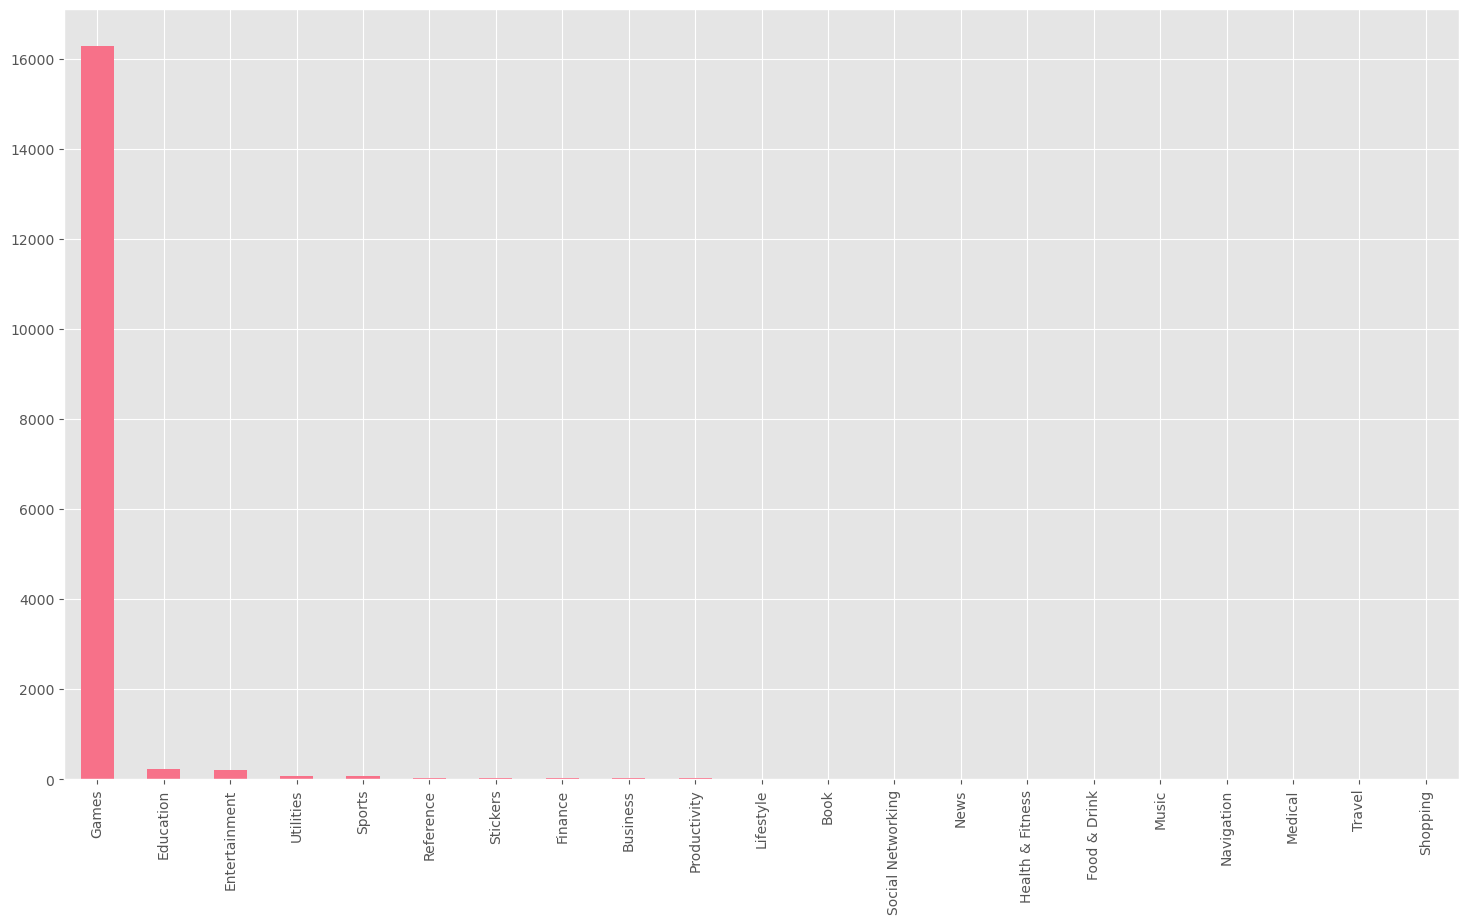

In [282]:
# смотрим жанры по популярности
data.Primary_Genre.value_counts().plot(kind = 'bar')

<AxesSubplot:>

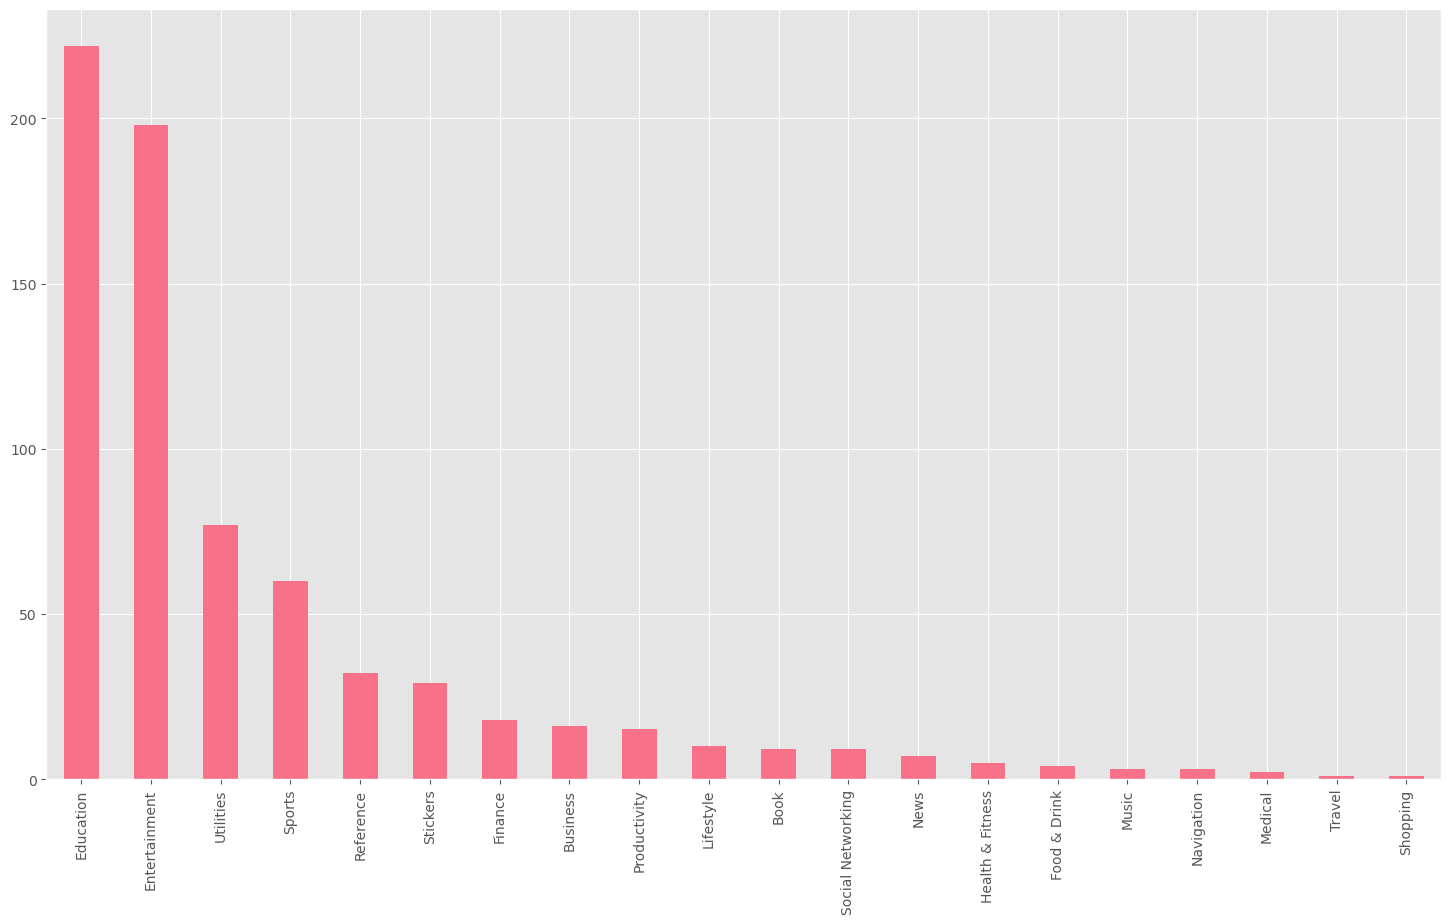

In [283]:
# теперь без игр
data.query('Primary_Genre != "Games"')['Primary_Genre'].value_counts().plot(kind = 'bar')

In [64]:
data.query('Primary_Genre != "Games"').head()

,ID,Name,Average_User_Rating,User_Rating_Count,Price,In-app_Purchases,Description,Developer,Age_Rating,Languages,Size,Primary_Genre,Genres,Original_Release_Date,Current_Version_Release_Date,free,in_app_paid,invoice_month,size_bin
21,291723451,All You Can Eat,2.0,30.0,0.99,0,"""'All You Can Eat' is a very enjoyable game. I...",Armin Heinrich,9+,EN,4.341760,Entertainment,"Entertainment, Games, Casual, Strategy",2008-09-24,2019-03-16,not_free,free,2008-09-01,1
112,318280645,Age of Conquest: Europe,3.5,267.0,3.99,0,"""European Conquest for iPad, iPhone and iPod T...",Noble Master LLC,12+,EN,39.074816,Entertainment,"Entertainment, Games, Board, Strategy",2009-06-16,2018-12-10,not_free,free,2009-06-01,1
138,324331173,Stock Wars - Virtual Investing,3.5,3015.0,0.00,1.99,"""Stock Wars puts you in the fast paced world o...",Continuous Integration Inc.,4+,EN,10.139648,Finance,"Finance, Simulation, Games, Strategy",2009-10-29,2017-11-28,free,not_free,2009-10-01,1
155,328415391,Yahoo Fantasy Football & more,3.5,199585.0,0.00,0,"""The best in Fantasy Football, Baseball, Baske...",Yahoo,17+,"AR, BN, BG, CA, HR, CS, DA, NL, EN, ET, FI, FR...",145.777664,Sports,"Sports, Games, Sports, Strategy",2009-08-09,2019-07-27,free,free,2009-08-01,4
165,331513453,IpickMega,NaN,NaN,0.99,0,IpickMega delivers four separate random number...,"Avruk, LLC",4+,EN,1.612800,Entertainment,"Entertainment, Casino, Games, Strategy",2009-09-23,2017-02-16,not_free,free,2009-09-01,1


Можем заметить что подавляющее большинство составляют Games, но если посмотреть на датасет и без Games, то остальные приложения составляют игры или около игровые приложения на подобие Stock Wars - Virtual Investing

_____
### Посморим как будут различаться наши показатели в зависимости от того платная игра или нет
* User_Rating_Count
* Average_User_Rating - Number of ratings internationally, null means it is below 5

**Срдедняя оценка пользователей**

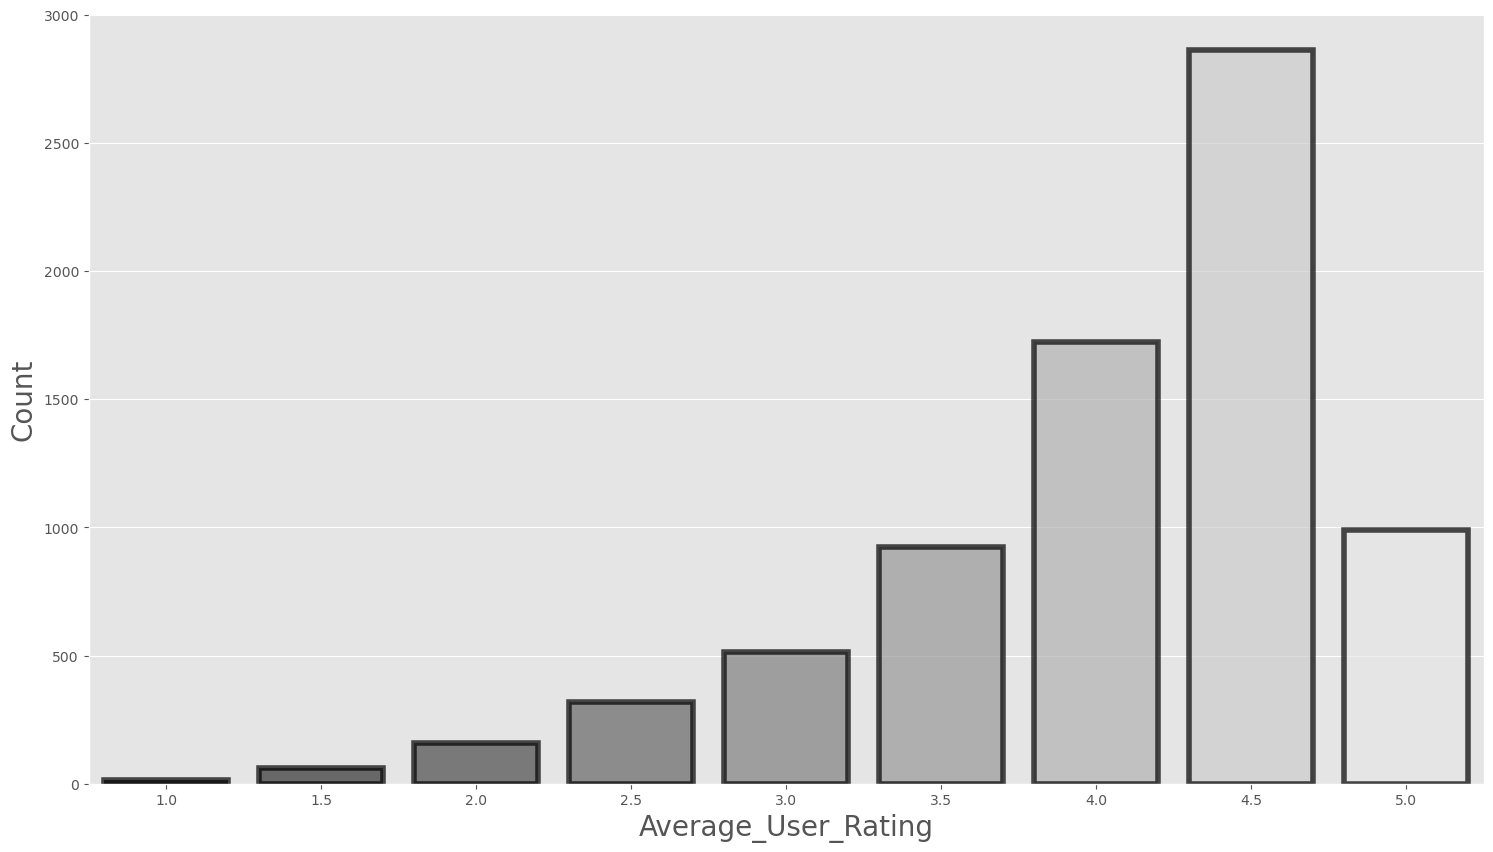

In [82]:
bold('**Срдедняя оценка пользователей**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = data, x ='Average_User_Rating', palette = 'gray', alpha = 0.7, linewidth=4, edgecolor= 'black')
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Average_User_Rating', fontsize = 20)
plt.show()

Очень мало игр с оценкой 1-3, большинство получили 4-4.5, игр с 5 баллами столько же, сколько и с 3.5

In [48]:
# группировка по платности игры , счтиаем среднее, медиану и кол-во Average_User_Rating
data.groupby(['free','in_app_paid'])['Average_User_Rating'].agg(['mean', 'median','count']).reset_index()

,free,in_app_paid,mean,median,count
0,free,free,3.898505,4.0,2074
1,free,not_free,4.155493,4.5,4251
2,not_free,free,3.963658,4.0,853
3,not_free,not_free,4.107050,4.5,383


In [284]:
# группировка по платности игры , счтиаем среднее, медиану и кол-во User_Rating_Count
data.groupby(['free','in_app_paid'])['User_Rating_Count'].agg(['mean', 'median','count']).reset_index()

,free,in_app_paid,mean,median,count
0,free,free,313.203033,0.0,7122
1,free,not_free,2898.464598,10.0,7090
2,not_free,free,431.276113,0.0,2202
3,not_free,not_free,2142.102867,27.0,593


Выводы по группировке:
* На Average_User_Rating практически никак не влияет платная игра или нет и есть ли внутриигровые платежи
* На User_Rating_Count в первую очередь сильно влияет внутриигровые платежи. Люди лучше относятся к игре, если там есть внутриигровые транзакции
    * Предложение бесплатных игр с внутриигровыми платежами в 2 раза больше, чем полностью бесплатных (что логично)
    * Полностью бесплатные игры получают среднюю оценку в 4.5 раза ниже, чем бесплатные игры с внутриигровыми. (предполагаю что это из-за встроенной рекламы в полность бесплатные игры)
    * Полностью бесплатные игры получают самый низкий рейтинг как по медиане, так и по средним оценкам
    * Полностью платные игры присутствуют намного реже остальных, но у них самые высокие рейтинги по медиане и вторые по средней оценке полсле платных и внутриигровыми

______
### Посмотрим на оценки в зависимости от возрастного рейтинга

**Кол-во игр в зависимости от возрастного рейтинга**

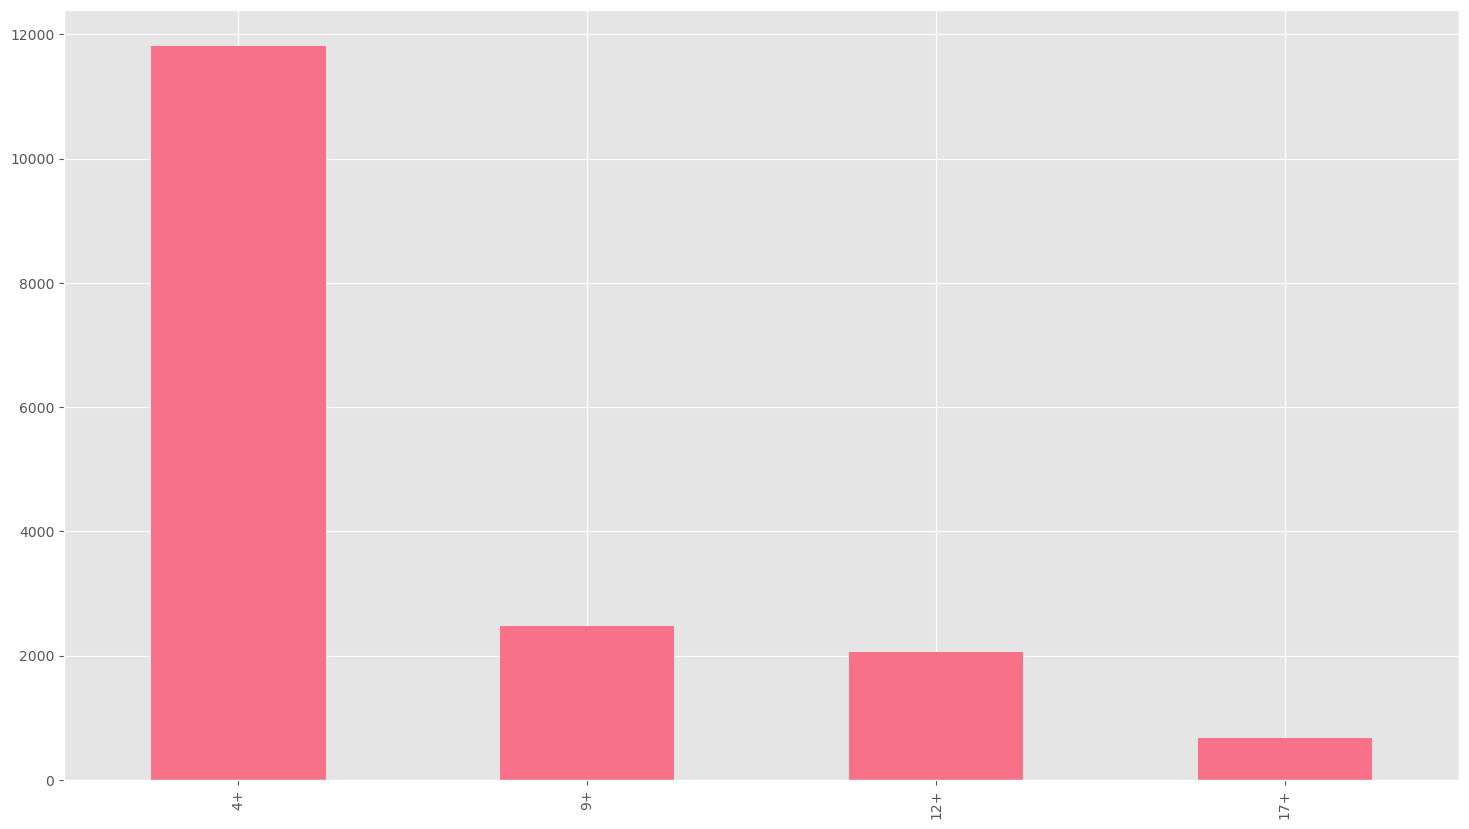

In [109]:
bold('**Кол-во игр в зависимости от возрастного рейтинга**')
data.Age_Rating.value_counts().plot(kind = "bar");

**Зависимость age_rating и Average_User_Rating**

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


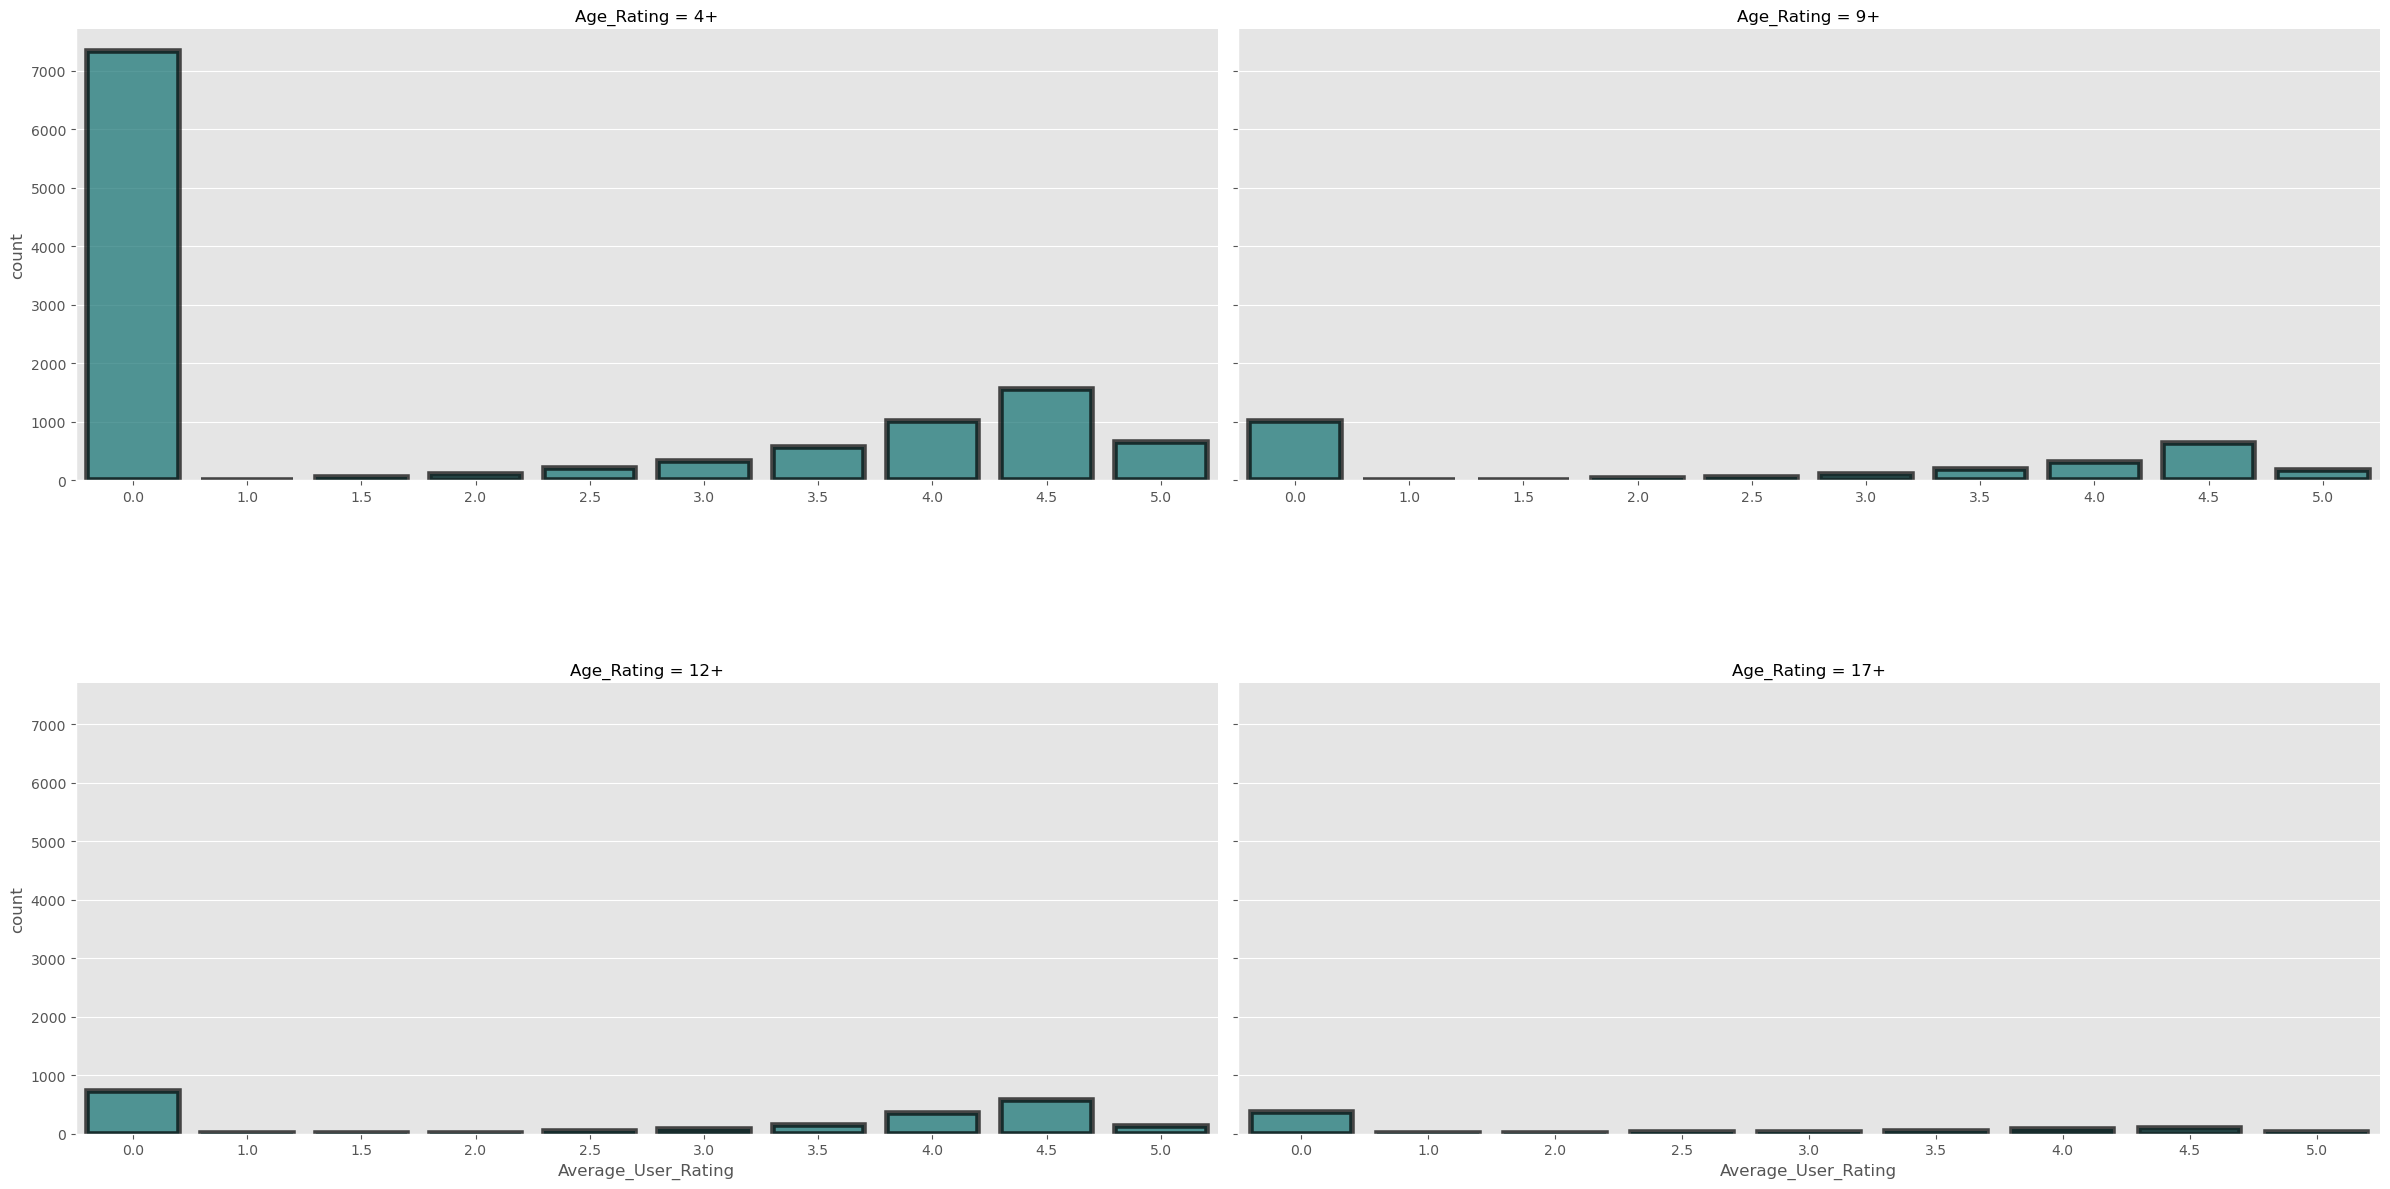

In [287]:
bold('**Зависимость age_rating и Average_User_Rating**')
ax = sns.FacetGrid(data, col="Age_Rating", col_wrap=2, height=6, aspect=2,  sharex=False)
ax.map(sns.countplot, 'Average_User_Rating', color="teal", alpha = 0.7, linewidth=4, edgecolor= 'black')
plt.subplots_adjust(hspace=0.45)
plt.show();

### Вывод: 
* Подавляющее кол-во игр для 4+ лет
* Тенденция на оценки везде одинаковая, поэтому вывод - возрастной рейтинг не влияет на оценки

**Зависимость age_rating и среднего кол-ва оценок**

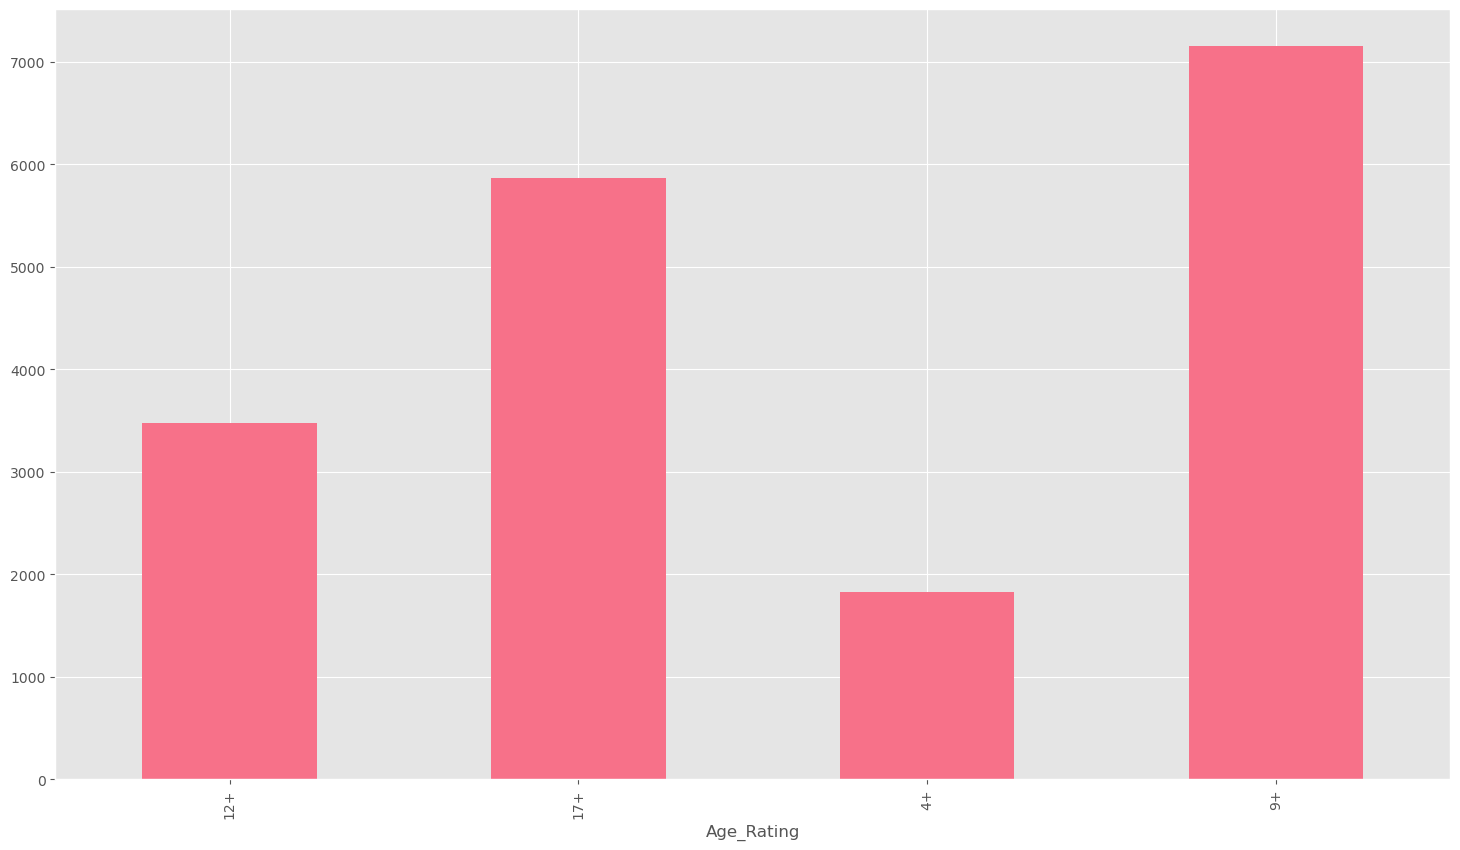

In [122]:
bold('**Зависимость age_rating и среднего кол-ва оценок**')
data.groupby('Age_Rating')['User_Rating_Count'].mean().plot(kind = 'bar');

In [123]:
data.groupby('Age_Rating')['User_Rating_Count'].agg(['mean', 'median','count']).reset_index()

,Age_Rating,mean,median,count
0,12+,3473.691673,104.0,1333
1,17+,5862.698962,35.0,289
2,4+,1823.093575,32.0,4467
3,9+,7155.008832,72.5,1472


### Вывод:
* Самое низкое среднее и медианное кол-во оценок в 4+
* Самое высокое с отрывом 9+
* Самая высокая медиана 12+

______
### Посмотрим на динамику выпускамых игр в год

**Диаграмма релиза новых игр**

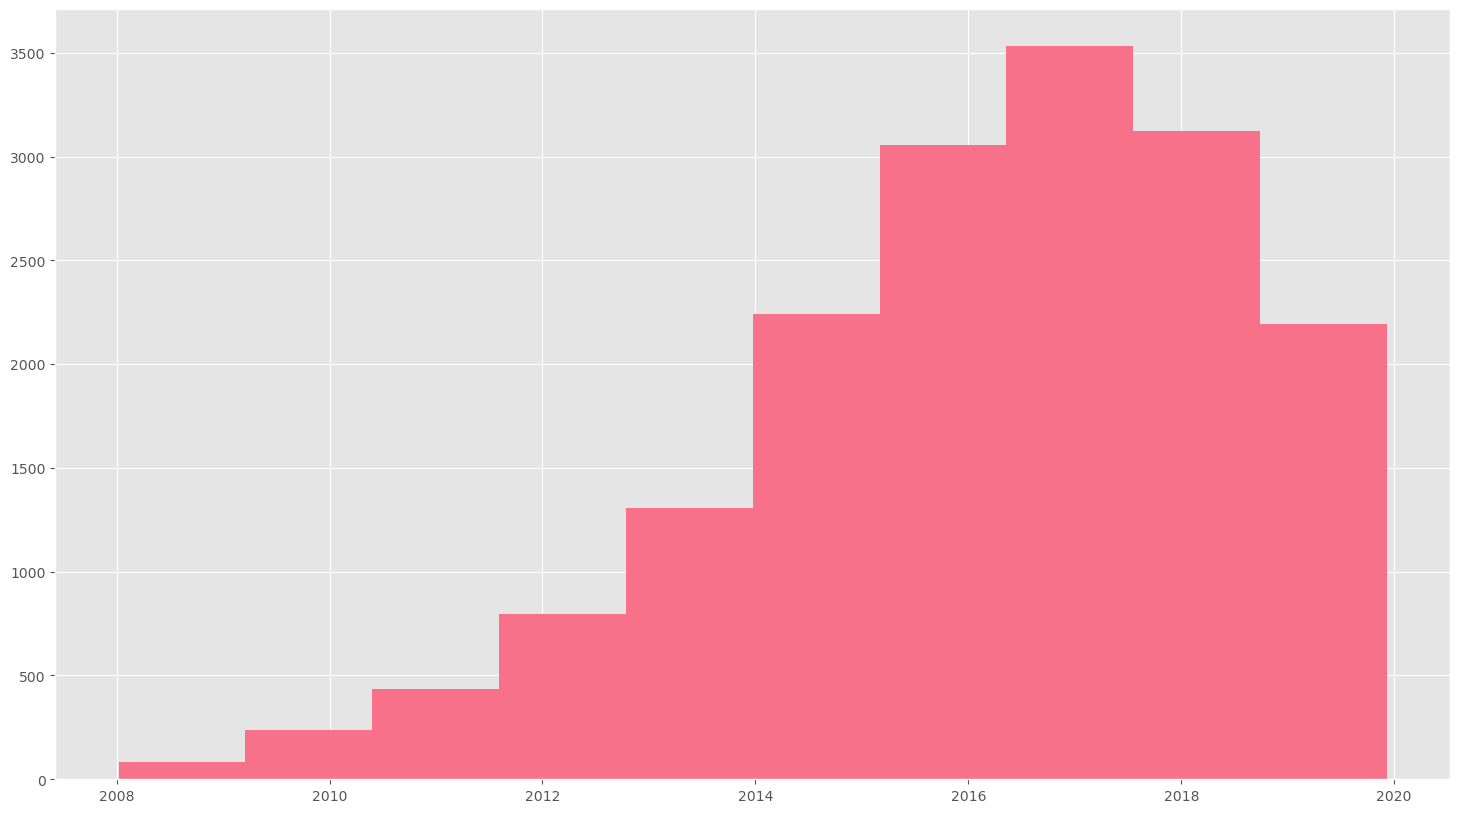

In [288]:
bold('**Диаграмма релиза новых игр**')
data.Original_Release_Date.hist();

Может есть разница в какой месяц выпускать игру?

In [289]:
# получим название месяца
data['order_month'] = data['Original_Release_Date'].dt.month_name() 


**Кол-во выпускаемых новых игр по месяцам**

<AxesSubplot:xlabel='order_month'>

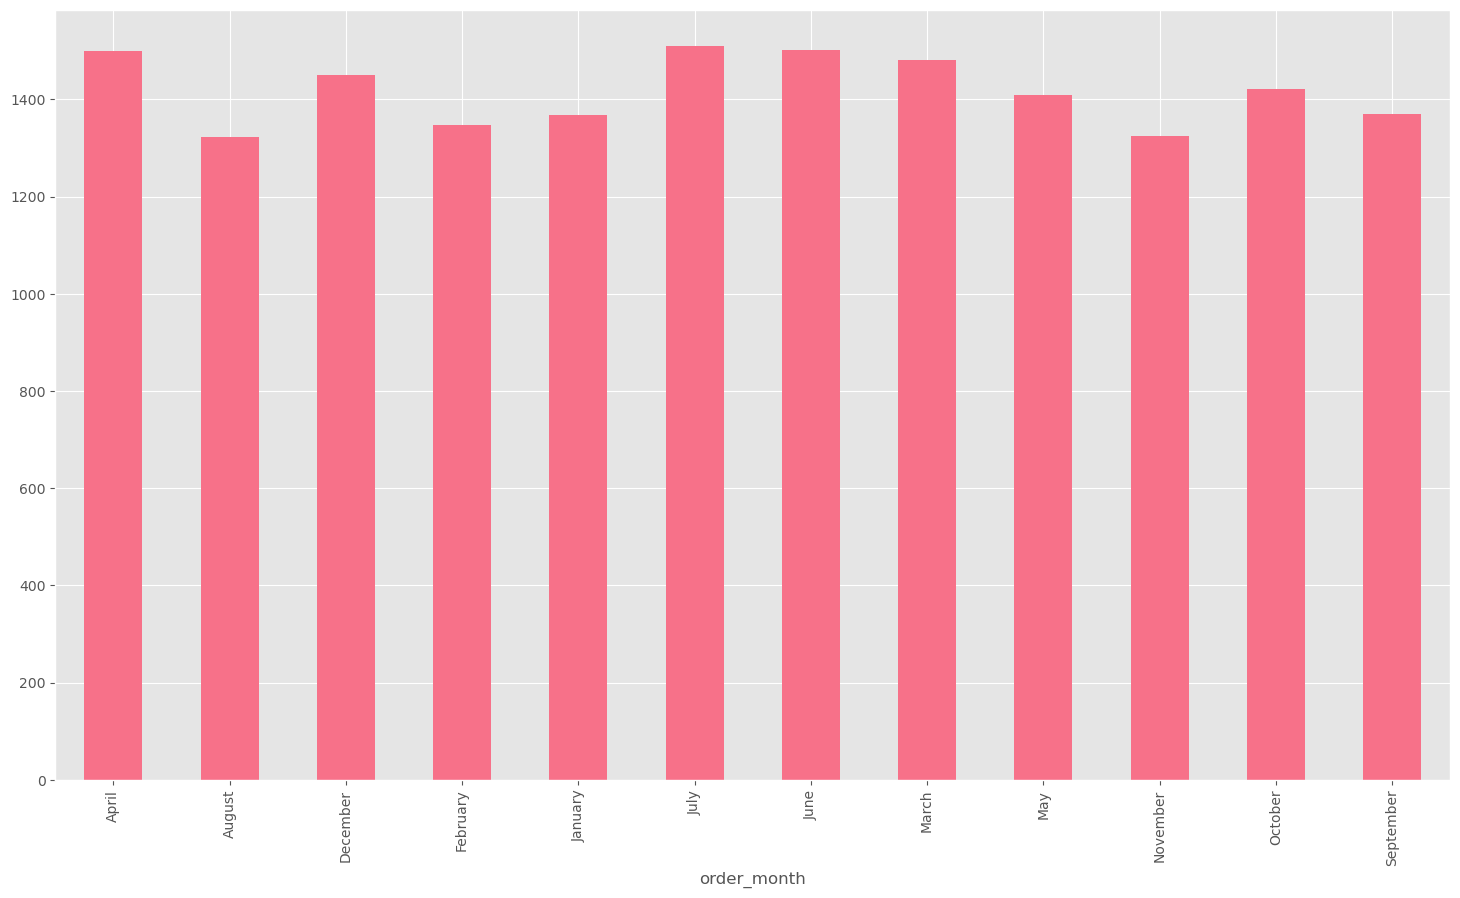

In [303]:
bold('**Кол-во выпускаемых новых игр по месяцам**')
data.groupby('order_month').Name.count().plot(kind = 'bar');

Выпуск не зависит от месяца. Посмотрим влияет ли месяц на популярность игры

In [307]:
data.groupby('order_month')['User_Rating_Count'].agg(['mean', 'count'])

,mean,count
order_month,,
April,912.968000,1500
August,1645.264550,1323
December,1524.339310,1450
February,4079.103935,1347
January,991.132310,1368
July,1368.357853,1509
June,1184.579228,1502
March,1244.053981,1482
May,1221.588652,1410


Вот здесь интересный момент, 'февральские' игры получают намного больше отзывов чем остальные. Посмотрим топ 10 дропов игр в феврале

In [300]:
data.query('order_month == "February"').groupby('Name')['User_Rating_Count'].sum().nlargest(10)

Name
Clash of Clans                          3032734.0
Clash Royale                            1277095.0
Hidden Objects: Gardens of Time          134595.0
Farm Story\u2122                         129759.0
Fire Emblem Heroes                       120283.0
Wedding Dash                             101209.0
Catcha Mouse                              95971.0
RollerCoaster Tycoon\xae Touch\u2122      59993.0
Infection Bio War                         44275.0
Zombie Tower Shooting Defense             32964.0
Name: User_Rating_Count, dtype: float64

Нашли Clash of Clans и Clash Royale, одни из самых популярных игр. Попробуем их убрать и посмотреть что получится

In [302]:
data.query('Name != "Clash of Clans " & Name != "Clash Royale"').groupby('order_month')['User_Rating_Count'].agg(['mean', 'count'])

,mean,count
order_month,,
April,912.968000,1500
August,1645.264550,1323
December,1524.339310,1450
February,3133.326895,1346
January,991.132310,1368
July,1368.357853,1509
June,1184.579228,1502
March,1244.053981,1482
May,1221.588652,1410


Все равно февраль сильно выделяется на фоне остальных месяцев

#### Выводы: 
* Кол-во выпускаемых игр сильно росло до 2017г
* К 2020г кол-во выпускаемых игр упало до уровня 2015г
* Игры выпущеные в феврале собрали намного больше отзывов

_____
### Посмотрим кол-во игр в разбивке по размеру
#### Bins (в мегабайтах):
    1.0-40
    2.40-70
    3.70-100
    4.100-500
    5.500-4000

<AxesSubplot:xlabel='size_bin'>

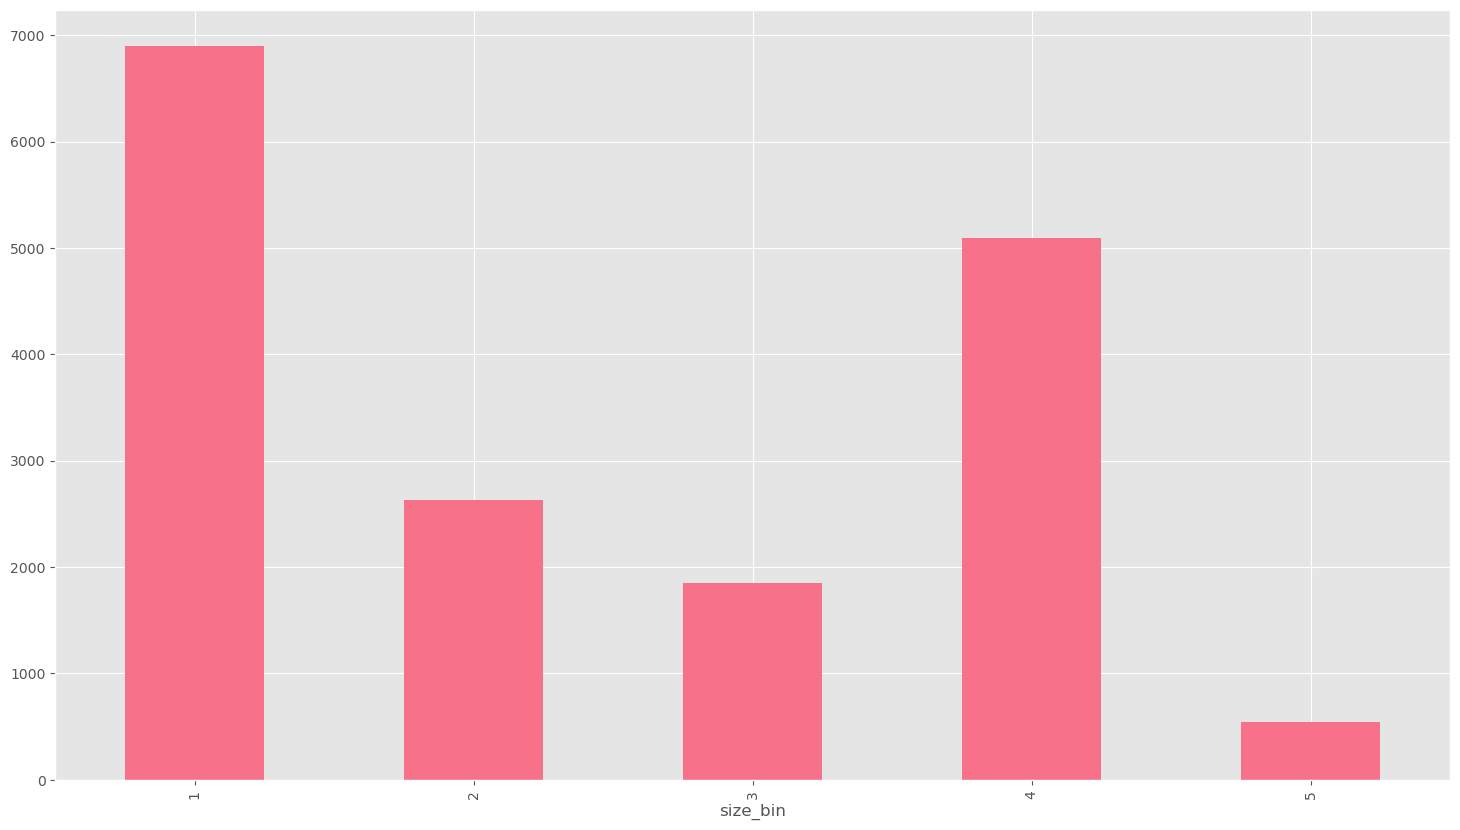

In [148]:
data.groupby('size_bin').Name.count().plot(kind = 'bar')

Разобьем по size и посчитаем срединий и медианный кол-во отзывов

In [156]:
bold('**User_Rating_Count в зависимости от размера**')
data.groupby('size_bin')['User_Rating_Count'].agg(['mean','median','count'])

**User_Rating_Count в зависимости от размера**

,mean,median,count
size_bin,,,
1,1103.620851,24.0,2350
2,1738.729895,42.5,1144
3,1528.070671,48.0,849
4,6014.334740,80.5,2844
5,5403.973190,158.0,373


In [157]:
bold('**Average_User_Rating в зависимости от размера**')
data.groupby('size_bin')['Average_User_Rating'].agg(['mean','median','count'])

**Average_User_Rating в зависимости от размера**

,mean,median,count
size_bin,,,
1,3.877872,4.0,2350
2,4.084790,4.5,1144
3,4.160777,4.5,849
4,4.159810,4.5,2844
5,4.158177,4.5,373


Выводы:
* Самый большое кол-во игр приходится на size_bin - 0-40 и 100-500 мегабайт
* Самое маленькое среднее и медианное кол-во отзывов приходится на size_bin - 0-40
* Чем больше размер игры - тем охотнее люди оставляют отзывы
* Average_User_Rating как и прежде не особо что-то показывает

_______
### Посмотрим какой разарботчик самый популярный

**Топ 10 разарботчиков по User_Rating_Count**

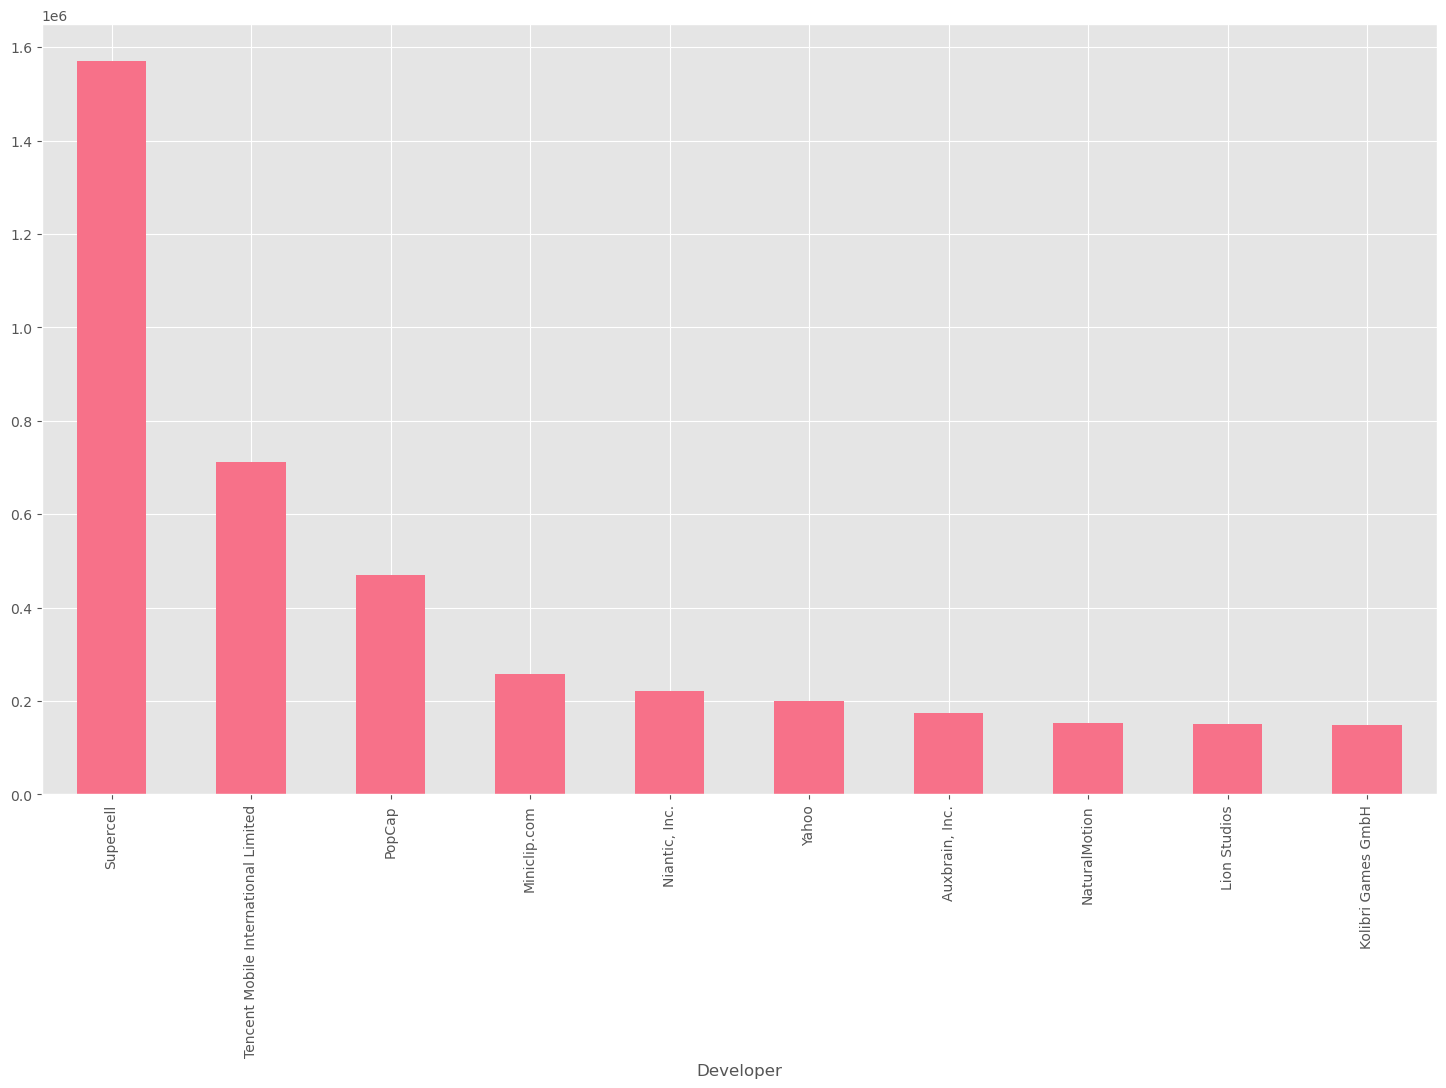

In [172]:
bold('**Топ 10 разарботчиков по User_Rating_Count**')
data.groupby('Developer')['User_Rating_Count'].mean().nlargest(10).plot(kind = 'bar');

In [221]:
bold('**Топ 10 разарботчиков по User_Rating_Count**')
data.groupby('Developer')['User_Rating_Count'].agg(['mean','count']).sort_values(by = 'mean', ascending = False).head(10)

**Топ 10 разарботчиков по User_Rating_Count**

,mean,count
Developer,,
Supercell,1.570205e+06,3
Tencent Mobile International Limited,7.114090e+05,1
PopCap,4.695620e+05,1
Miniclip.com,2.578520e+05,1
"Niantic, Inc.",2.220550e+05,2
Yahoo,1.995850e+05,1
"Auxbrain, Inc.",1.745910e+05,1
NaturalMotion,1.539360e+05,2
Lion Studios,1.511570e+05,3


In [223]:
bold('**Топ 10 разарботчиков по кол-ву игр**')
data.groupby('Developer')['Name'].count().sort_values(ascending = False).nlargest(10)

**Топ 10 разарботчиков по кол-ву игр**

Developer
Tapps Tecnologia da Informa\xe7\xe3o Ltda.    123
Vikash Patel                                  107
Netsummit Marketing, Inc.                      95
GabySoft                                       85
NetSummit Enterprises, Inc.                    77
Andrew Kudrin                                  62
MmpApps Corp.                                  61
Domyung Kim                                    57
Amy Prizer                                     46
Detention Apps                                 42
Name: Name, dtype: int64

Можем заметить что в топ 10 по User_Rating_Count у всех разработчиков всего 1-3 продукта. Хотя у самого крупного по кол-ву игр разработчика более 100 игр

Теперь разберемся с колонкой Genres, в ней очень много слов для описания и везде есть слово Games, которое можно дропнуть. Далее преобразуем эту колонку и посмотрим самые популярные сочетания.

In [308]:
data['Genres'] = data['Genres'].apply(lambda s : s.replace('Games','').replace('&',' ').replace(',', ' ').split())


AttributeError: 'tuple' object has no attribute 'replace'

In [309]:
data['Genres'] = data['Genres'].apply(tuple)

In [310]:
bold('**Топ 10 сочетаний жанров по кол-ву игр**')
data['Genres'].value_counts().to_frame().nlargest(10,'Genres')

**Топ 10 сочетаний жанров по кол-ву игр**

,Genres
"(Strategy, Puzzle)",778
"(Puzzle, Strategy)",694
"(Strategy,)",588
"(Strategy, Action)",483
"(Simulation, Strategy)",465
"(Strategy, Simulation)",462
"(Action, Strategy)",421
"(Strategy, Puzzle, Entertainment)",357
"(Puzzle, Strategy, Entertainment)",342
"(Strategy, Casual)",339


In [311]:
bold('**Топ 10 игр по рейтингу юзеров + их сочетание жанров**')
data.groupby(['Genres','Name'])['User_Rating_Count'].agg(['mean', 'count']).sort_values(by = 'mean', ascending = False).head(10)

**Топ 10 игр по рейтингу юзеров + их сочетание жанров**

,,mean,count
Genres,Name,,
"(Action, Entertainment, Strategy)",Clash of Clans,3032734.0,1
"(Strategy, Entertainment, Action)",Clash Royale,1277095.0,1
"(Action, Strategy)",PUBG MOBILE,711409.0,1
"(Strategy, Entertainment, Adventure)",Plants vs. Zombies\u2122 2,469562.0,1
"(Strategy, Role, Playing, Health, Fitness)",Pok\xe9mon GO,439776.0,1
"(Strategy, Action)",Boom Beach,400787.0,1
"(Strategy, Entertainment, Simulation)","Cash, Inc. Fame & Fortune Game",374772.0,1
"(Simulation, Strategy, Entertainment)",Idle Miner Tycoon: Cash Empire,283035.0,1
"(Strategy, Entertainment, Simulation)",TapDefense,273687.0,1


#### Посмотрим зависит ли кол-во отзывов от того платная игра или нет в разрезе Age_Rating

In [312]:
data.groupby(['Age_Rating','free','in_app_paid'])['User_Rating_Count'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean')

,Age_Rating,free,in_app_paid,mean,count
12,9+,free,free,244.980057,702
8,4+,free,free,290.137557,5525
10,4+,not_free,free,325.029259,1538
2,12+,not_free,free,407.563574,291
0,12+,free,free,475.554702,521
4,17+,free,free,555.834225,374
6,17+,not_free,free,842.129630,54
14,9+,not_free,free,895.608150,319
11,4+,not_free,not_free,987.138047,297
7,17+,not_free,not_free,1225.875000,16


Опять же можем заметить что наличие внутриигровых транзакций положительно кореллирует с кол-вом оставляемых отзывов

# Финальные выводы:
* Никакие имеющиеся у нас показатели не влияют на оценку, которую пользователь ставит игре. По всем разрезам средняя оценка 4-4.5 баллов
* Пользователи очень нехотно ставят оценку ниже 3.5, а 3.5 ставят с такой же частотой как и 5 баллов
* Люди хорошо относятся:
    * к бесплатным играм где есть внутриигровые транзакции
    * к платным играм где есть внутриигровые транзакции
    * к играм с рейтингом 9+ и выше
    * чем больше размер игры, тем охотнее люди оставляют отзывы
* Люди очень неохотно оставляют отзывы в полностью бесплатных играх и в платных играх без внутриигровых платежей
* Самое большое кол-во игр - 4+ лет, но в отзывов в среднем в несколько раз меньше
* Нету никакой разницы в какой месяц выпускать игру
* Топ разработчики по кол-ву отзывов имеют всего 1-3 игры